# **Data Import**

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_excel("https://archive.ics.uci.edu/ml/machine-learning-databases/00193/CTG.xls", sheet_name="Data",header=1,nrows=2126)

df = df.dropna(axis=1, how='all')

print(df)

         b     e  AC  FM  UC  DL  DS  DP  DR   LB  ...  C  D  E  AD  DE  LD  \
0      240   357   0   0   0   0   0   0   0  120  ... -1 -1 -1  -1  -1  -1   
1        5   632   4   0   4   2   0   0   0  132  ... -1 -1 -1   1  -1  -1   
2      177   779   2   0   5   2   0   0   0  133  ... -1 -1 -1   1  -1  -1   
3      411  1192   2   0   6   2   0   0   0  134  ... -1 -1 -1   1  -1  -1   
4      533  1147   4   0   5   0   0   0   0  132  ... -1 -1 -1  -1  -1  -1   
...    ...   ...  ..  ..  ..  ..  ..  ..  ..  ...  ... .. .. ..  ..  ..  ..   
2121  2059  2867   0   0   6   0   0   0   0  140  ... -1 -1  1  -1  -1  -1   
2122  1576  2867   1   0   9   0   0   0   0  140  ... -1 -1  1  -1  -1  -1   
2123  1576  2596   1   0   7   0   0   0   0  140  ... -1 -1  1  -1  -1  -1   
2124  1576  3049   1   0   9   0   0   0   0  140  ... -1 -1  1  -1  -1  -1   
2125  2796  3415   1   1   5   0   0   0   0  142  ... -1 -1 -1  -1  -1  -1   

      FS  SUSP  CLASS  NSP  
0      1    -1      9 

# **Data Cleaning**

In [26]:
#Drop the repeated (normalized) columns & leakage columns & duplicate rows
df = df.drop(columns=['AC.1', 'FM.1', 'UC.1', 'DL.1', 'DS.1', 'DP.1'], errors='ignore')
df = df.drop(columns=['CLASS', 'A', 'B', 'C', 'D', 'E', 'AD', 'DE', 'LD', 'FS', 'SUSP'], errors='ignore')
df = df.drop_duplicates()

# Convert all columns to numeric, coercing errors to NaN
df = df.apply(pd.to_numeric, errors='coerce')

#Map NSP column to 0 (Normal), 1 (Suspect), and 2 (Pathological)
df['NSP'] = df['NSP'] - 1

print("Columns:", df.columns)

print(df);

#Separate input columns and output column
target_col = "NSP"

X = df.drop(columns=[target_col])
y = df[target_col]

print("\nMissing values per column:")
print(df.isnull().sum())

print("\nTarget distribution:")
print(y.value_counts(normalize=True))

classes = ['Normal', 'Suspect', 'Pathologic']

Columns: Index(['b', 'e', 'AC', 'FM', 'UC', 'DL', 'DS', 'DP', 'DR', 'LB', 'ASTV',
       'MSTV', 'ALTV', 'MLTV', 'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode',
       'Mean', 'Median', 'Variance', 'Tendency', 'NSP'],
      dtype='object')
         b     e  AC  FM  UC  DL  DS  DP  DR   LB  ...  Min  Max  Nmax  \
0      240   357   0   0   0   0   0   0   0  120  ...   62  126     2   
1        5   632   4   0   4   2   0   0   0  132  ...   68  198     6   
2      177   779   2   0   5   2   0   0   0  133  ...   68  198     5   
3      411  1192   2   0   6   2   0   0   0  134  ...   53  170    11   
4      533  1147   4   0   5   0   0   0   0  132  ...   53  170     9   
...    ...   ...  ..  ..  ..  ..  ..  ..  ..  ...  ...  ...  ...   ...   
2121  2059  2867   0   0   6   0   0   0   0  140  ...  137  177     4   
2122  1576  2867   1   0   9   0   0   0   0  140  ...  103  169     6   
2123  1576  2596   1   0   7   0   0   0   0  140  ...  103  170     5   
2124  1576  3049   

# **Train/Test Split**

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("\nTraining class distribution:")
print(y_train.value_counts())
print("\nTest class distribution:")
print(y_test.value_counts())

Training set shape: (1692, 24)
Test set shape: (423, 24)

Training class distribution:
NSP
0    1318
1     234
2     140
Name: count, dtype: int64

Test class distribution:
NSP
0    329
1     59
2     35
Name: count, dtype: int64


# **Apply SMOTE to Training Data**

In [28]:
from imblearn.over_sampling import SMOTE
from collections import Counter

print("Before SMOTE:", Counter(y_train))

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("After SMOTE:", Counter(y_train_smote))

Before SMOTE: Counter({0: 1318, 1: 234, 2: 140})
After SMOTE: Counter({0: 1318, 2: 1318, 1: 1318})


# **Model Evaluation Function**

In [29]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix, classification_report

def evaluate_model(model, y_test, y_pred):
    # Accuracy
    acc = balanced_accuracy_score(y_test, y_pred)
    print("Test Balanced Accuracy:", acc)

    # Macro F1-score
    f1 = f1_score(y_test, y_pred, average="macro")
    print("Test Macro F1-score:", f1)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    plt.figure(figsize=(6,4))
    sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # Detailed classification report
    print(classification_report(y_test, y_pred))

# **XGBoost Classifier**

Test Balanced Accuracy: 0.9254443356859513
Test Macro F1-score: 0.9147126176811512


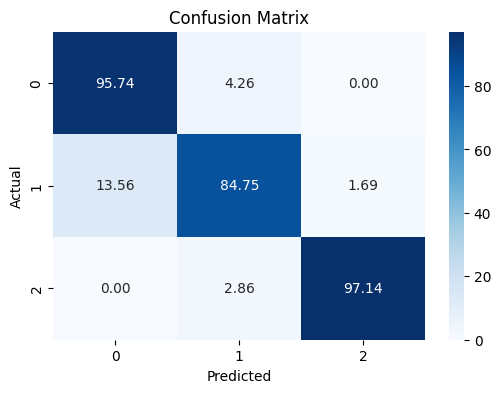

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       329
           1       0.77      0.85      0.81        59
           2       0.97      0.97      0.97        35

    accuracy                           0.94       423
   macro avg       0.91      0.93      0.91       423
weighted avg       0.95      0.94      0.94       423



In [30]:
import xgboost as xgb

# Baseline XGBoost model
xgb_base = xgb.XGBClassifier(
    objective='multi:softmax',        # CTG is multi-class (Normal, Suspect, Pathological)
    num_class=len(np.unique(y_train)),
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# Fit
xgb_base.fit(X_train_smote, y_train_smote)

# Predict
y_pred_xgb = xgb_base.predict(X_test)

evaluate_model(xgb_base, y_test, y_pred_xgb)

# **Explain General Model Behaviour**





## **Feature Importance Explanation Function**

In [31]:
def show_feature_importance(model, importance_type):
    importance_dict = model.get_booster().get_score(importance_type=importance_type)

    # Convert to DataFrame for easier handling
    importance_df = pd.DataFrame(list(importance_dict.items()), columns=['Feature','Gain'])

    # Normalize the importance
    importance_df['Gain_norm'] = importance_df['Gain'] / importance_df['Gain'].sum()

    # Sort by normalized gain
    importance_df = importance_df.sort_values('Gain_norm', ascending=True)

    plt.figure(figsize=(8,6))
    bars = plt.barh(importance_df['Feature'], importance_df['Gain_norm'])
    plt.xlabel('Normalized Gain')
    plt.title('XGBoost Feature Importance (Normalized)')

    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.001, bar.get_y() + bar.get_height()/2, f'{width:.2f}', va='center')

    plt.show()

## **SHAP Display Function**

In [32]:
import shap

def show_shap(model):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    for i in range(3):
        print()
        fig = plt.figure()
        plt.title(f"SHAP Summary — Class {i} ({classes[i]})", fontsize=14, pad=15)
        shap.summary_plot(shap_values[..., i], X_test, feature_names=X_test.columns, show=False)
        plt.show()

## **Explain Model**

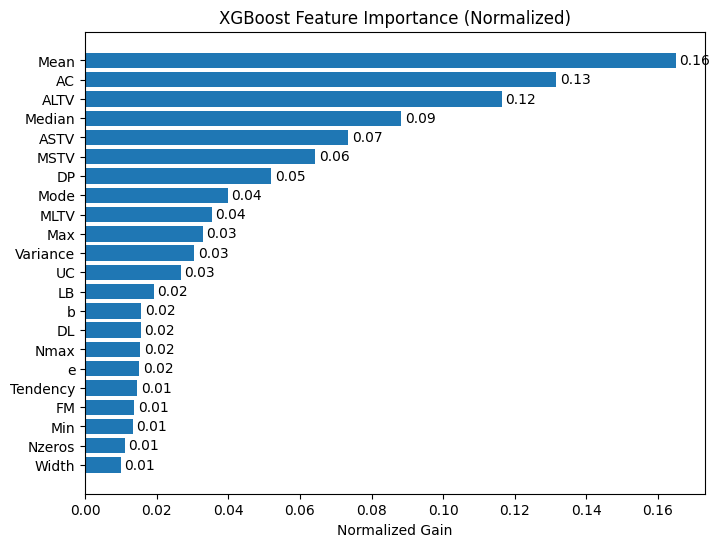

In [33]:
#Feature Importance
show_feature_importance(xgb_base, importance_type='gain')

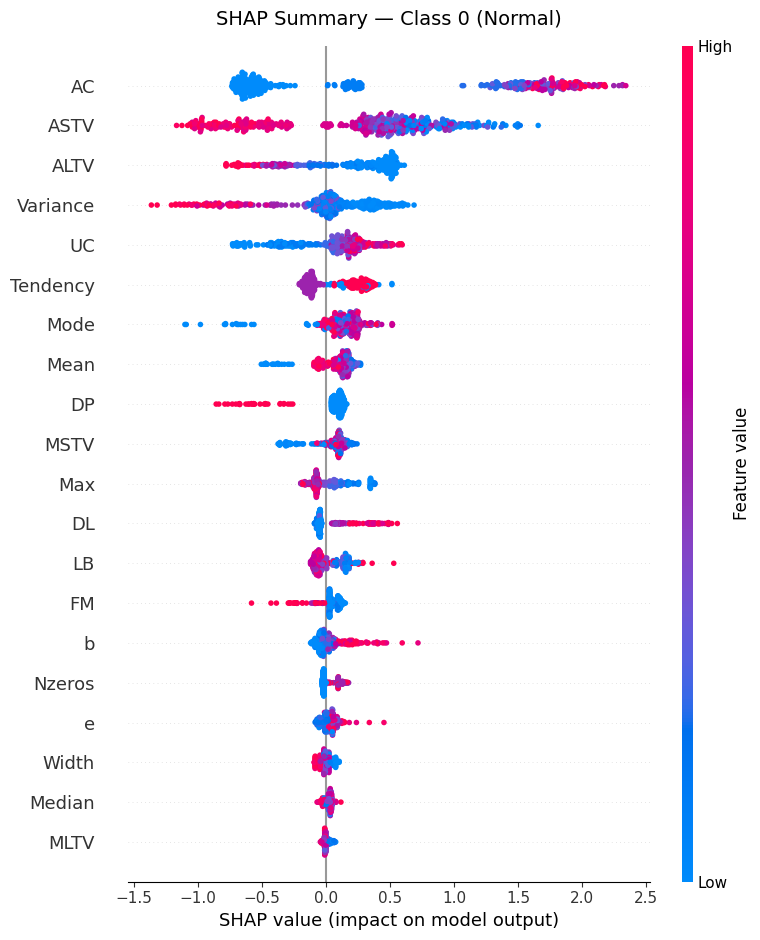

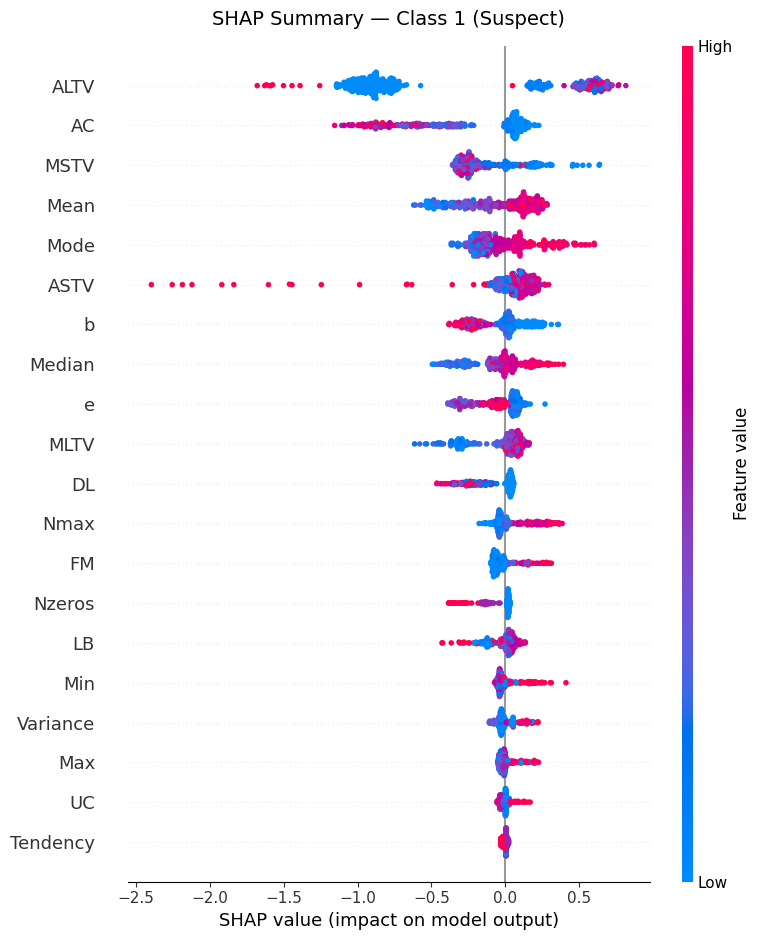

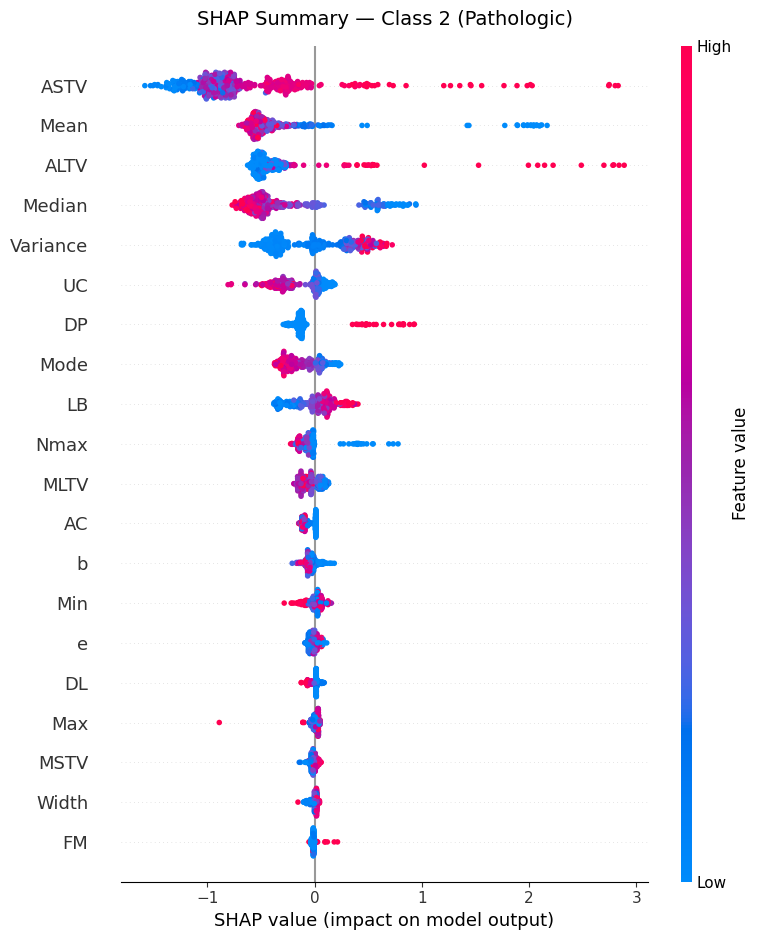

In [34]:
#SHAP
show_shap(xgb_base)

# **Optimize XGBoost with SearchCV** (for macro-F1 score)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters:
{'subsample': 0.8, 'n_estimators': 400, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.7}

Best Cross-Validation Macro F1-score: 0.9750
Test Balanced Accuracy: 0.9260522384215136
Test Macro F1-score: 0.9380356261497734


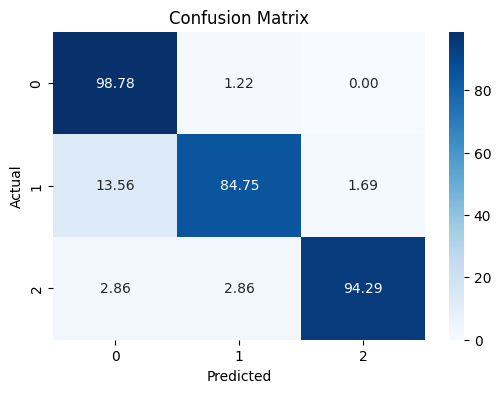

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       329
           1       0.91      0.85      0.88        59
           2       0.97      0.94      0.96        35

    accuracy                           0.96       423
   macro avg       0.95      0.93      0.94       423
weighted avg       0.96      0.96      0.96       423


🏅 Top 10 Parameter Sets (by Macro F1):
 mean_test_score  std_test_score                                                                                                                                       params
        0.974967        0.012211 {'subsample': 0.8, 'n_estimators': 400, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.7}
        0.974182        0.013465    {'subsample': 0.8, 'n_estimators': 400, 'min_child_weight': 5, 'max_depth': 9, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}
        0.973425        0.012746 {'subsample': 0.7, 'n_es

In [35]:
from sklearn.model_selection import RandomizedSearchCV

#Random Search Space
param_dist = {
    'n_estimators': [100, 200, 400],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3],
}

xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    n_jobs=-1,
    random_state=42
)

random_xgb = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_xgb.fit(X_train_smote, y_train_smote)

#Best Model
print("Best Parameters:")
print(random_xgb.best_params_)
print("\nBest Cross-Validation Macro F1-score: {:.4f}".format(random_xgb.best_score_))

best_xgb = random_xgb.best_estimator_

y_pred_best_xbg = best_xgb.predict(X_test)

evaluate_model(best_xgb, y_test, y_pred_best_xbg)

results_df = pd.DataFrame(random_xgb.cv_results_)
results_df_sorted = results_df.sort_values(by='mean_test_score', ascending=False)

print("\n🏅 Top 10 Parameter Sets (by Macro F1):")
print(results_df_sorted[['mean_test_score', 'std_test_score', 'params']].head(10).to_string(index=False))


# **Optimize XGBoost with SearchCV** (for Balanced Accuracy score)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters:
{'subsample': 0.8, 'n_estimators': 400, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.7}

Best Cross-Validation Balanced Accuracy: 0.9750
Test Balanced Accuracy: 0.9260522384215136
Test Macro F1-score: 0.9380356261497734


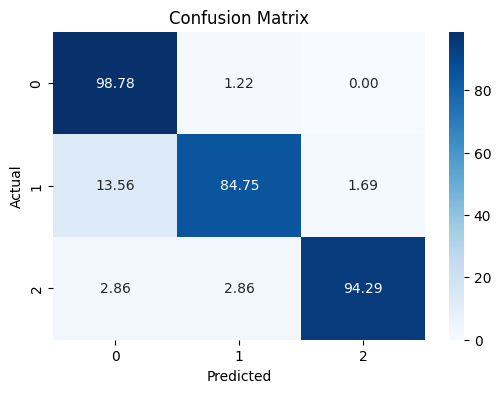

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       329
           1       0.91      0.85      0.88        59
           2       0.97      0.94      0.96        35

    accuracy                           0.96       423
   macro avg       0.95      0.93      0.94       423
weighted avg       0.96      0.96      0.96       423


🏅 Top 10 Parameter Sets (by Balanced Accuracy):
 mean_test_score  std_test_score                                                                                                                                       params
        0.974958        0.012183 {'subsample': 0.8, 'n_estimators': 400, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.7}
        0.974201        0.013392    {'subsample': 0.8, 'n_estimators': 400, 'min_child_weight': 5, 'max_depth': 9, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}
        0.973443        0.012664 {'subsample': 0

In [38]:
from sklearn.model_selection import RandomizedSearchCV

#Random Search Space
param_dist = {
    'n_estimators': [100, 200, 400],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3],
}

xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    n_jobs=-1,
    random_state=42
)

random_xgb = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring='balanced_accuracy',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_xgb.fit(X_train_smote, y_train_smote)

#Best Model
print("Best Parameters:")
print(random_xgb.best_params_)
print("\nBest Cross-Validation Balanced Accuracy: {:.4f}".format(random_xgb.best_score_))

best_xgb = random_xgb.best_estimator_

y_pred_best_xbg = best_xgb.predict(X_test)

evaluate_model(best_xgb, y_test, y_pred_best_xbg)

results_df = pd.DataFrame(random_xgb.cv_results_)
results_df_sorted = results_df.sort_values(by='mean_test_score', ascending=False)

print("\n🏅 Top 10 Parameter Sets (by Balanced Accuracy):")
print(results_df_sorted[['mean_test_score', 'std_test_score', 'params']].head(10).to_string(index=False))


# **Optimal Model**

Test Balanced Accuracy: 0.9260522384215136
Test Macro F1-score: 0.9380356261497734


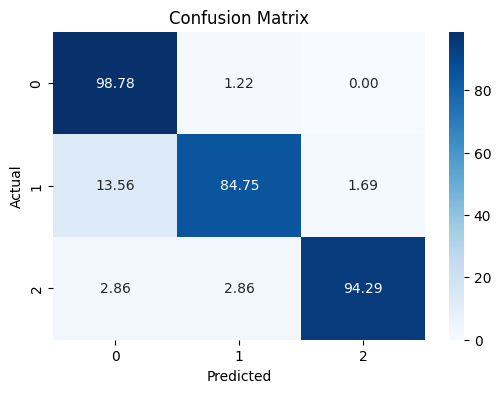

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       329
           1       0.91      0.85      0.88        59
           2       0.97      0.94      0.96        35

    accuracy                           0.96       423
   macro avg       0.95      0.93      0.94       423
weighted avg       0.96      0.96      0.96       423



In [42]:
import xgboost as xgb

# Optimized XGBoost model
xgb_opt = xgb.XGBClassifier(
    objective='multi:softmax',        # CTG is multi-class (Normal, Suspect, Pathological)
    num_class=len(np.unique(y_train)),
    n_estimators=400,
    max_depth=5,
    learning_rate=0.05,
    gamma=0.1,
    subsample=0.8,
    colsample_bytree=0.7,
    min_child_weight=1,
    random_state=42,
    n_jobs=-1
)

# Fit
xgb_opt.fit(X_train_smote, y_train_smote)

# Predict
y_pred_xgb_opt = xgb_opt.predict(X_test)

evaluate_model(xgb_opt, y_test, y_pred_xgb_opt)

# **Explain Fined-Tuned Model Behaviour**

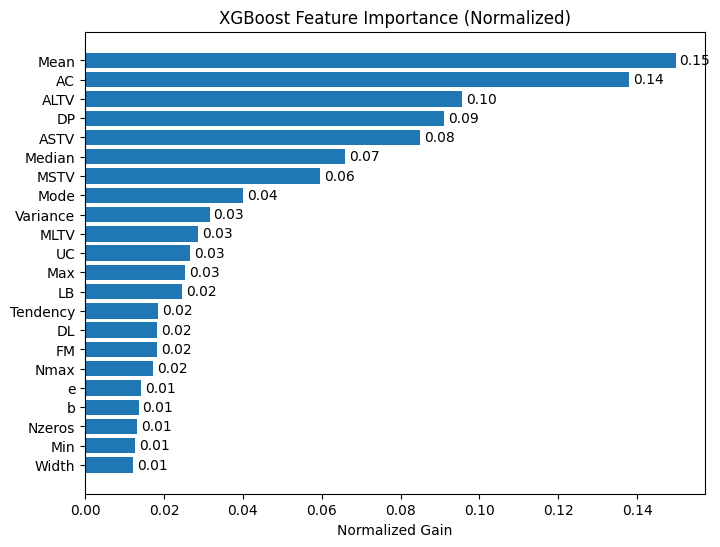

In [43]:
show_feature_importance(xgb_opt, importance_type='gain')

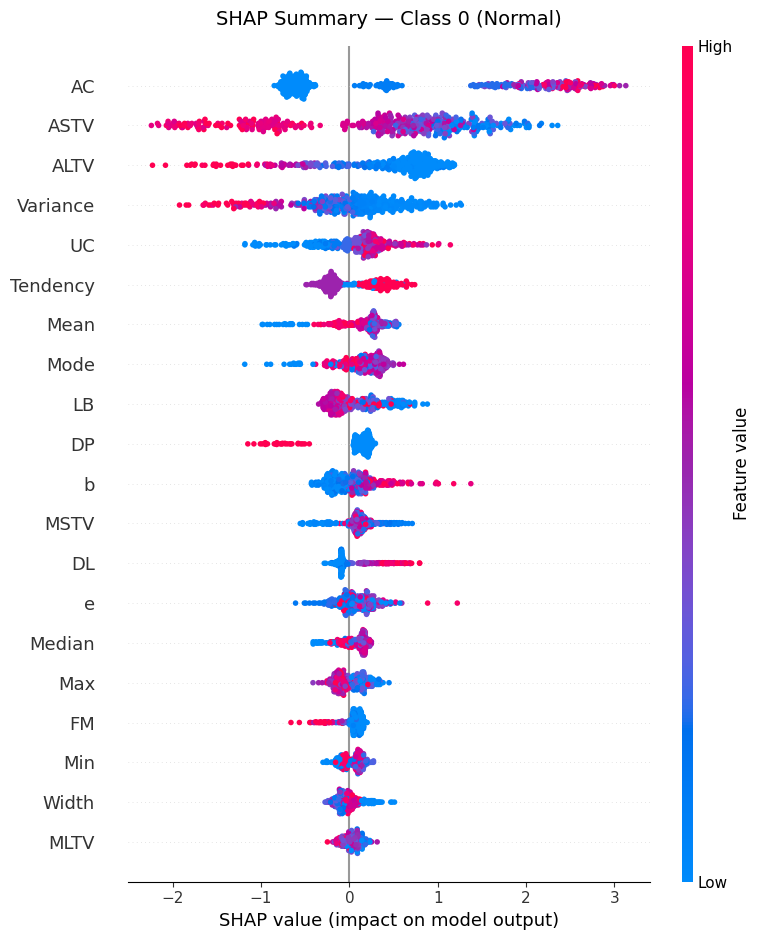

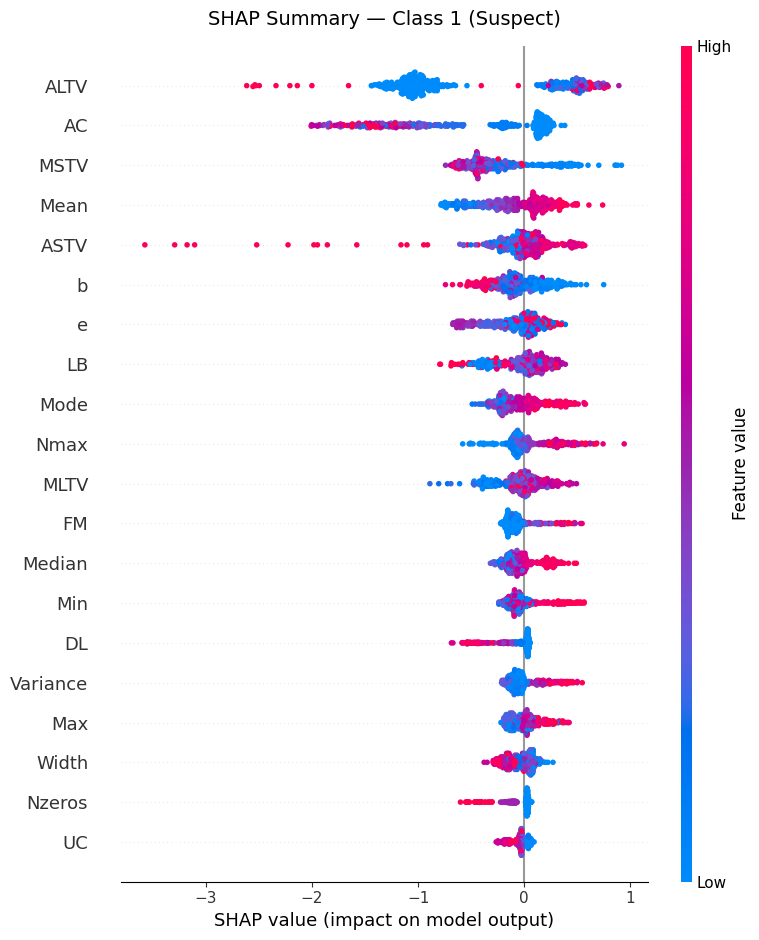

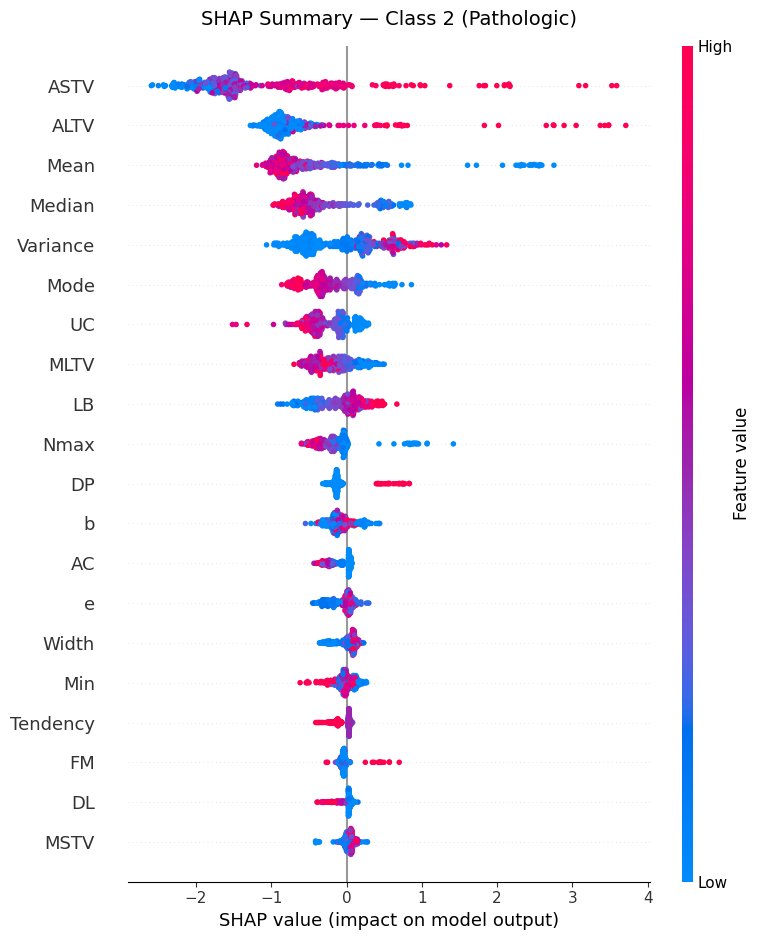

In [44]:
show_shap(xgb_opt)

In [45]:
xgb_base.save_model("xgb_base.json")
xgb_opt.save_model("xgb_opt.json")

In [ ]:
import joblib

# Assuming model is trained as `model`
joblib.dump(xgb_opt, "gb_model.pkl")
print("Model saved to gb_model.pkl")